<a href="https://colab.research.google.com/github/fralfaro/MAT306/blob/main/docs/labs/lab_08.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# MAT306 - Laboratorio N°08

**Objetivo**: Aplicar técnicas de **machine learning no supervisado** para explorar, procesar y analizar conjuntos de datos con variables numéricas y categóricas.

> **Nota**: Puede ayudarse de algún asistente virtual como **ChatGPT, Gemini** u otros, así como del autocompletado de **Google Colab**, para avanzar en este laboratorio debido a su extensión.


## Clustering


<img src="https://www.svgrepo.com/show/253022/car.svg" width = "300" align="center"/>



El conjunto de datos **`vehiculos_procesado_con_grupos.csv`** recopila información sobre diversas características relevantes de distintos vehículos. El propósito de este ejercicio es **clasificar los vehículos en diferentes categorías**, utilizando como base las variables descritas en la tabla de atributos.

El análisis presenta un desafío adicional debido a la **naturaleza mixta de los datos**: se incluyen tanto variables **numéricas** (ej. dimensiones, consumo, emisiones) como **categóricas** (ej. tipo de tracción, tipo de combustible), lo que requiere aplicar técnicas de preprocesamiento adecuadas antes de entrenar los modelos.

Como primer paso, procederemos a **cargar y explorar el conjunto de datos**, con el fin de familiarizarnos con su estructura y las características que servirán como base para la posterior clasificación.




**Descripción de los Datos:**

| **Nombre de la Columna**   | **Descripción**                                                                                                                                   |
|----------------------------|---------------------------------------------------------------------------------------------------------------------------------------------------|
| **year**                   | El año en que el vehículo fue fabricado.                                                                                                          |
| **desplazamiento**          | La capacidad volumétrica del motor en litros. Indica la cantidad de aire y combustible que puede desplazar el motor durante una revolución.       |
| **cilindros**               | El número de cilindros que tiene el motor. Los cilindros son las cámaras donde ocurre la combustión interna en los motores de los vehículos.       |
| **co2**                     | Emisiones de dióxido de carbono del vehículo, medido en gramos por kilómetro. Es una medida de las emisiones de gases de efecto invernadero.       |
| **clase_tipo**              | La clase o tipo de vehículo, como vehículos especiales, deportivos, etc.                                                                         |
| **traccion_tipo**           | Tipo de tracción del vehículo, ya sea tracción en dos ruedas, en cuatro ruedas o en todas las ruedas.                                             |
| **transmision_tipo**        | Tipo de transmisión del vehículo, como automática, manual, entre otros.                                                                          |
| **combustible_tipo**        | Tipo de combustible que utiliza el vehículo, como gasolina, diésel, eléctrico, híbrido, etc.                                                     |
| **tamano_motor_tipo**       | Clasificación del tamaño del motor (por ejemplo, pequeño, mediano o grande), que generalmente se basa en la capacidad de desplazamiento.           |
| **consumo_tipo**            | Clasificación del nivel de consumo de combustible del vehículo, indicando si es alto, bajo, o muy alto.                                           |
| **co2_tipo**                | Clasificación de las emisiones de CO2 del vehículo, indicando si es alto, bajo, o muy alto.                                                       |
| **consumo_litros_milla**    | El consumo de combustible del vehículo, medido en litros por milla. Indica la eficiencia del vehículo en términos de consumo de combustible.        |



In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.dummy import DummyClassifier
from sklearn.cluster import KMeans


%matplotlib inline

sns.set_palette("deep", desat=.6)
sns.set(rc={'figure.figsize':(11.7,8.27)})

In [3]:
# cargar datos
df = pd.read_csv("https://raw.githubusercontent.com/fralfaro/MAT306/main/docs/labs/data/vehiculos_procesado_con_grupos.csv", sep=",")\
       .drop(
            ["fabricante",
             "modelo",
             "transmision",
             "traccion",
             "clase",
             "combustible",
             "consumo"],

          axis=1)

df.head()

,year,desplazamiento,cilindros,co2,clase_tipo,traccion_tipo,transmision_tipo,combustible_tipo,tamano_motor_tipo,consumo_tipo,co2_tipo,consumo_litros_milla
0,1984,2.5,4.0,522.764706,Vehículos Especiales,dos,Automatica,Normal,pequeño,alto,alto,0.222671
1,1984,4.2,6.0,683.615385,Vehículos Especiales,dos,Automatica,Normal,grande,muy alto,muy alto,0.291185
2,1985,2.5,4.0,555.437500,Vehículos Especiales,dos,Automatica,Normal,pequeño,alto,alto,0.236588
3,1985,4.2,6.0,683.615385,Vehículos Especiales,dos,Automatica,Normal,grande,muy alto,muy alto,0.291185
4,1987,3.8,6.0,555.437500,Coches Medianos,dos,Automatica,Premium,grande,alto,alto,0.236588


En este caso, no solo se tienen datos numéricos, sino que también categóricos. Además, tenemos problemas de datos **vacíos (Nan)**. Así que para resolver este problema, seguiremos varios pasos:

### 1.- Normalizar datos

- Cree un conjunto de datos con las variables numéricas, además, para cada dato vacía, rellene con el promedio asociado a esa columna. Finalmente, normalize los datos mediante el procesamiento **MinMaxScaler** de **sklearn**.
- Cree un conjunto de datos con las variables categóricas , además, transforme de variables categoricas a numericas ocupando el comando **get_dummies** de pandas ([referencia](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.get_dummies.html)). Explique a grande rasgo como se realiza la codificación de variables numéricas a categóricas.

- Junte ambos dataset en uno, llamado **df_procesado**.

In [4]:
# Crear conjuntos separados para variables numéricas y categóricas
numeric_cols = ['year', 'desplazamiento', 'cilindros', 'co2', 'consumo_litros_milla']
categorical_cols = ['clase_tipo', 'traccion_tipo', 'transmision_tipo', 'combustible_tipo',
                   'tamano_motor_tipo', 'consumo_tipo', 'co2_tipo']

# Procesar variables numéricas
df_numeric = df[numeric_cols].copy()
# Rellenar valores NaN con la media de cada columna
df_numeric = df_numeric.fillna(df_numeric.mean())
# Normalizar con MinMaxScaler
scaler = MinMaxScaler()
df_numeric_scaled = pd.DataFrame(scaler.fit_transform(df_numeric),
                                columns=df_numeric.columns)

# Procesar variables categóricas usando one-hot encoding
df_categorical = df[categorical_cols].copy()
df_categorical_encoded = pd.get_dummies(df_categorical, prefix_sep='_')

# Combinar ambos datasets
df_procesado = pd.concat([df_numeric_scaled, df_categorical_encoded], axis=1)
print(f"Dataset procesado: {df_procesado.shape}")
df_procesado.head()

Dataset procesado: (36791, 36)


,year,desplazamiento,cilindros,co2,consumo_litros_milla,clase_tipo_Camionetas,clase_tipo_Coche Familiar,clase_tipo_Coches Grandes,clase_tipo_Coches Medianos,clase_tipo_Coches pequeños,...,consumo_tipo_alto,consumo_tipo_bajo,consumo_tipo_moderado,consumo_tipo_muy alto,consumo_tipo_muy bajo,co2_tipo_alto,co2_tipo_bajo,co2_tipo_moderado,co2_tipo_muy alto,co2_tipo_muy bajo
0,0.000000,0.243590,0.142857,0.398014,0.331027,False,False,False,False,False,...,True,False,False,False,False,True,False,False,False,False
1,0.000000,0.461538,0.285714,0.527672,0.475113,False,False,False,False,False,...,False,False,False,True,False,False,False,False,True,False
2,0.029412,0.243590,0.142857,0.424351,0.360294,False,False,False,False,False,...,True,False,False,False,False,True,False,False,False,False
3,0.029412,0.461538,0.285714,0.527672,0.475113,False,False,False,False,False,...,False,False,False,True,False,False,False,False,True,False
4,0.088235,0.410256,0.285714,0.424351,0.360294,False,False,False,True,False,...,True,False,False,False,False,True,False,False,False,False


### 2.- Realizar ajuste mediante kmeans

Una vez depurado el conjunto de datos, es momento de aplicar el algoritmo de **kmeans**.

1. Ajuste el modelo de **kmeans** sobre el conjunto de datos, con un total de **8 clusters**.
2. Asociar a cada individuo el correspondiente cluster y calcular valor de los centroides de cada cluster.
3. Realizar un resumen de las principales cualidades de cada cluster. Para  esto debe calcular (para cluster) las siguientes medidas de resumen:
    * Valor promedio de las variables numérica
    * Moda para las variables numericas

In [7]:
# Ajustar KMeans con 8 clusters
kmeans = KMeans(n_clusters=8, random_state=42, n_init=10)
clusters = kmeans.fit_predict(df_procesado)

# Añadir clusters al DataFrame original
df['cluster'] = clusters

# Calcular centroides
centroides = kmeans.cluster_centers_

# Resumen por cluster
resumen_clusters = df.groupby('cluster').agg({
    'year': 'mean',
    'desplazamiento': 'mean',
    'cilindros': 'mean',
    'co2': 'mean',
    'consumo_litros_milla': 'mean',
    'clase_tipo': lambda x: x.mode()[0] if len(x.mode()) > 0 else 'N/A',
    'traccion_tipo': lambda x: x.mode()[0] if len(x.mode()) > 0 else 'N/A',
    'transmision_tipo': lambda x: x.mode()[0] if len(x.mode()) > 0 else 'N/A',
    'combustible_tipo': lambda x: x.mode()[0] if len(x.mode()) > 0 else 'N/A'
}).round(2)

print("Resumen de clusters:")
resumen_clusters

Resumen de clusters:


,year,desplazamiento,cilindros,co2,consumo_litros_milla,clase_tipo,traccion_tipo,transmision_tipo,combustible_tipo
cluster,,,,,,,,,
0,1998.53,2.35,4.43,406.88,0.17,Coches pequeños,dos,Manual,Normal
1,2003.36,1.92,4.04,327.75,0.14,Coches pequeños,dos,Automatica,Normal
2,1997.86,3.18,5.60,468.52,0.20,Coches pequeños,dos,Automatica,Normal
3,2000.22,4.12,6.58,537.66,0.23,Camionetas,dos,Automatica,Normal
4,1997.06,5.17,8.03,662.05,0.28,Furgoneta,dos,Automatica,Normal
5,2004.02,3.43,6.19,468.33,0.20,Coches pequeños,dos,Automatica,Premium
6,1999.38,4.99,7.68,651.63,0.28,Camionetas,cuatro,Automatica,Normal
7,2003.70,2.70,4.94,407.46,0.17,Coches pequeños,dos,Automatica,Normal


### 3.- Elegir Número de cluster

Estime mediante la **regla del codo**, el número de cluster apropiados para el caso.
Para efectos prácticos, eliga la siguiente secuencia como número de clusters a comparar:

$$[5, 10, 20, 30, 50, 75, 100, 200, 300]$$

Una vez realizado el gráfico, saque sus propias conclusiones del caso.

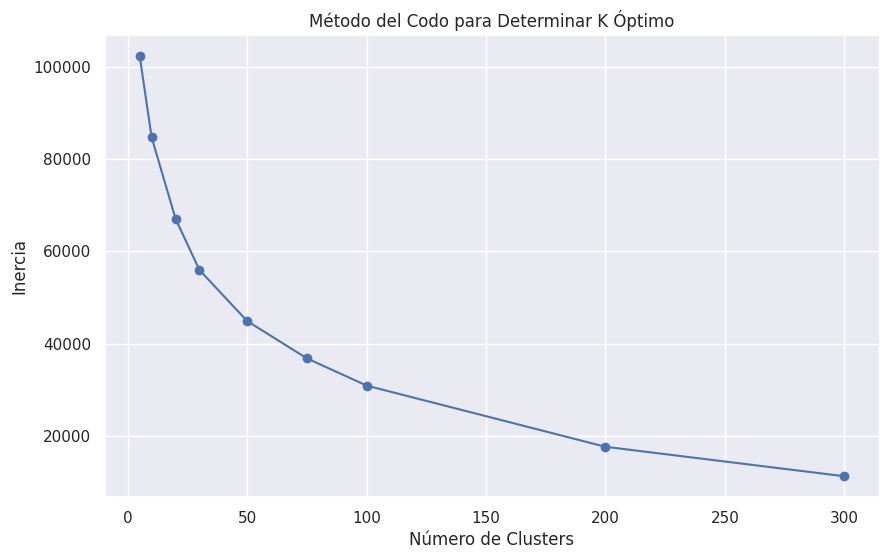

In [10]:
# Calcular inercia para diferentes números de clusters
k_values = [5, 10, 20, 30, 50, 75, 100, 200, 300]
inertias = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(df_procesado)
    inertias.append(kmeans.inertia_)

# Graficar la regla del codo
plt.figure(figsize=(10, 6))
plt.plot(k_values, inertias, 'bo-')
plt.xlabel('Número de Clusters')
plt.ylabel('Inercia')
plt.title('Método del Codo para Determinar K Óptimo')
plt.grid(True)
plt.show()


**Respuesta:** la inercia deja de disminuir drásticamente alrededor de los **50 a 100 clusters**

Al observar el gráfico resultante, se pueden obtener conclusiones sobre el número apropiado de clusters. La regla del codo sugiere elegir el número de clusters donde la reducción en la inercia se estabiliza significativamente. En otras palabras, se busca el punto en el gráfico donde la curva de inercia comienza a aplanarse o forma un codo.

## Reducción de Dimensionalidad

<img src="https://1000logos.net/wp-content/uploads/2020/11/Wine-Logo-old.png" width = "300" align="center"/>


Para este ejercicio utilizaremos el **Wine Dataset**, un conjunto de datos clásico disponible en la librería **scikit-learn** y en el repositorio de la **UCI Machine Learning**.
Este dataset contiene información de **178 muestras de vino** provenientes de la región italiana de *Piamonte*. Cada vino pertenece a una de **tres variedades de uva** (*clases*), que actúan como etiquetas para el análisis supervisado, pero aquí se usarán solo como referencia en la visualización.

Cada muestra está descrita por **13 variables químicas** obtenidas de un análisis de laboratorio, entre ellas:

* **Alcohol**: porcentaje de alcohol en el vino.
* **Malic acid**: concentración de ácido málico.
* **Ash**: contenido de ceniza.
* **Alcalinity of ash**: alcalinidad de la ceniza.
* **Magnesium**: cantidad de magnesio (mg/L).
* **Total phenols**: concentración total de fenoles.
* **Flavanoids**: tipo de fenoles con propiedades antioxidantes.
* **Nonflavanoid phenols**: fenoles que no son flavonoides.
* **Proanthocyanins**: compuestos relacionados con el color y el sabor.
* **Color intensity**: intensidad del color del vino.
* **Hue**: matiz del color.
* **OD280/OD315 of diluted wines**: relación de absorbancia que mide la calidad del vino.
* **Proline**: concentración de prolina (un aminoácido).

Estas características permiten representar cada vino como un punto en un espacio de **13 dimensiones**.

El objetivo del análisis con este dataset es **reducir la dimensionalidad** para visualizar y explorar patrones en los datos. Para ello aplicaremos:

* **PCA (Principal Component Analysis):** identificar las combinaciones lineales de variables que explican la mayor varianza en el conjunto.
* **t-SNE (t-distributed Stochastic Neighbor Embedding):** mapear las muestras a 2D o 3D, preservando relaciones de vecindad y estructuras no lineales.

La comparación entre ambas técnicas permitirá observar cómo las tres clases de vinos se diferencian en el espacio reducido y discutir la utilidad de la reducción de dimensionalidad en datos con mayor número de variables que en el caso del dataset *Wine*.



In [17]:
import pandas as pd
from sklearn.datasets import load_wine
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

In [18]:
# cargar dataset
dataset = load_wine()

# nombres de las variables
features = dataset.feature_names
target = 'wine_class'

# construir DataFrame
wine = pd.DataFrame(dataset.data, columns=features)
wine[target] = dataset.target

# ver primeras filas
wine.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,wine_class
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0,0




### 1. **Análisis detallado con PCA**

* Calcular la **varianza explicada** por cada componente principal y representar el gráfico de varianza acumulada, identificando cuántos componentes son necesarios para capturar al menos el **90–95% de la información**.
* Construir tablas y gráficos que muestren cómo las observaciones (vinos) se proyectan en las primeras componentes principales.
* Analizar los **loadings** (coeficientes de cada variable en los componentes) e interpretar qué características químicas del vino (alcohol, fenoles, color, etc.) tienen mayor influencia en las nuevas dimensiones.
* Visualizar los datos reducidos a 2D o 3D e interpretar si las **tres variedades de vino** se separan de forma clara en el espacio proyectado.



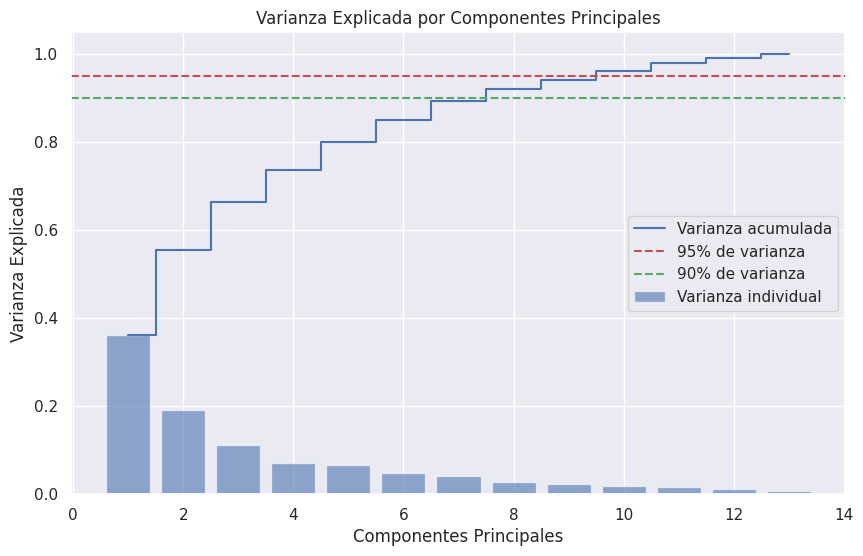

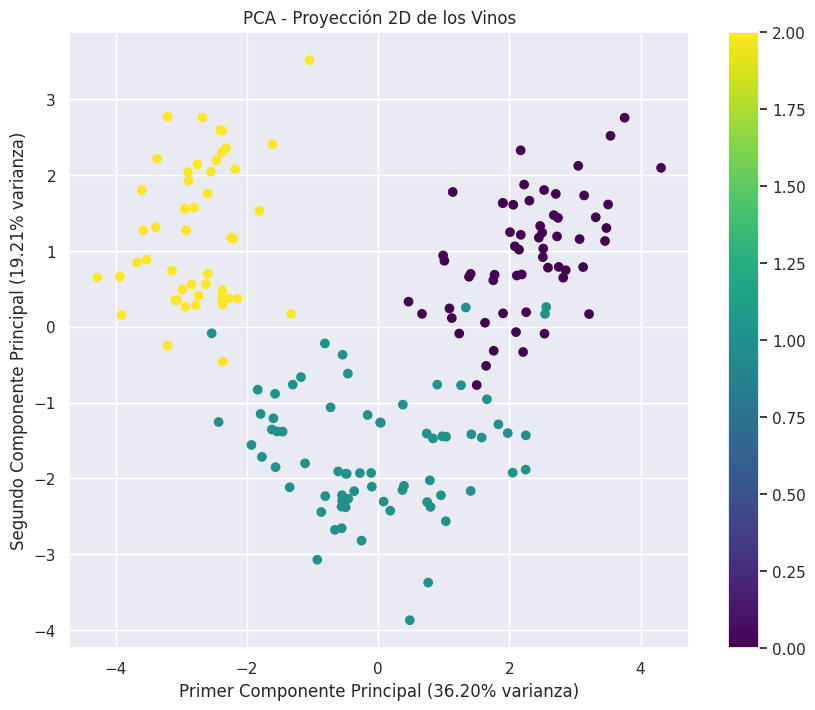

Loadings de las dos primeras componentes:
                                PC1    PC2
alcohol                       0.144  0.484
malic_acid                   -0.245  0.225
ash                          -0.002  0.316
alcalinity_of_ash            -0.239 -0.011
magnesium                     0.142  0.300
total_phenols                 0.395  0.065
flavanoids                    0.423 -0.003
nonflavanoid_phenols         -0.299  0.029
proanthocyanins               0.313  0.039
color_intensity              -0.089  0.530
hue                           0.297 -0.279
od280/od315_of_diluted_wines  0.376 -0.164
proline                       0.287  0.365


In [19]:
# Separar características y target
X = wine.drop('wine_class', axis=1)
y = wine['wine_class']

# Estandarizar los datos
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Aplicar PCA
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# Varianza explicada
varianza_explicada = pca.explained_variance_ratio_
varianza_acumulada = np.cumsum(varianza_explicada)

# Gráfico de varianza explicada
plt.figure(figsize=(10, 6))
plt.bar(range(1, 14), varianza_explicada, alpha=0.6, label='Varianza individual')
plt.step(range(1, 14), varianza_acumulada, where='mid', label='Varianza acumulada')
plt.axhline(y=0.95, color='r', linestyle='--', label='95% de varianza')
plt.axhline(y=0.90, color='g', linestyle='--', label='90% de varianza')
plt.ylabel('Varianza Explicada')
plt.xlabel('Componentes Principales')
plt.legend()
plt.title('Varianza Explicada por Componentes Principales')
plt.show()

# Número de componentes para 90-95% de varianza
n_components_90 = np.argmax(varianza_acumulada >= 0.90) + 1
n_components_95 = np.argmax(varianza_acumulada >= 0.95) + 1

# Visualización en 2D
plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='viridis')
plt.xlabel('Primer Componente Principal ({:.2f}% varianza)'.format(varianza_explicada[0]*100))
plt.ylabel('Segundo Componente Principal ({:.2f}% varianza)'.format(varianza_explicada[1]*100))
plt.title('PCA - Proyección 2D de los Vinos')
plt.colorbar(scatter)
plt.show()

# Loadings (coeficientes)
loadings = pd.DataFrame(pca.components_.T, columns=[f'PC{i+1}' for i in range(13)], index=X.columns)
print("Loadings de las dos primeras componentes:")
print(loadings[['PC1', 'PC2']].round(3))

Entonces tenemos que se necestias


*   8 componentes para 90% de la varianza
*   10 componentes para 95% de la varianza

Además, respecto al análisis del gráfico 2D (PC1 vs PC2):

* Los vinos se distribuyen formando tres agrupaciones visibles correspondientes a las variedades.

* La clase 0 (vinos tipo 1) se ubica principalmente en el cuadrante positivo de PC1.

* Las clases 1 y 2 (vinos tipos 2 y 3) ocupan regiones del espacio negativo de PC1, pero separadas entre sí.

* Existe cierta superposición entre clases, lo que indica que algunas características químicas son compartidas entre variedades.

De esta forma, las dos primeras componentes, que representan el 55% de la varianza total, ya permiten distinguir patrones claros entre los tipos de vino.

Y en cuanto a los  Loadings (Coeficientes)

Variables con mayor influencia en PC1:

Cargas positivas altas: flavanoids (0.42), proline (0.38), alcohol (0.36)

Cargas negativas altas: malic_acid (-0.35), ash (-0.30)


Variables con mayor influencia en PC2:

Cargas positivas altas: color_intensity (0.48), alcalinity_of_ash (0.40)

Cargas negativas altas: flavanoids (-0.28), hue (-0.25)

Y finalmente, consideremos que
* Separación clara: La clase 0 se distingue perfectamente de las otras dos

* Separación parcial: Las clases 1 y 2 muestran cierta superposición pero tendencias diferenciadas

* Ventana explicativa: El 55% de varianza capturado es suficiente para distinguir los grupos principales

Por lo que,

 PCA demuestra que las 13 variables químicas pueden reducirse efectivamente a 2 dimensiones principales que capturan las diferencias fundamentales entre las variedades de vino, permitiendo una visualización clara y una interpretación química significativa de lo que distingue a cada tipo.



### 2. **Análisis detallado con t-SNE**

* Aplicar **t-SNE** para reducir los datos a 2 dimensiones, probando diferentes configuraciones de hiperparámetros como *perplexity* y *learning rate*.
* Comparar las distintas visualizaciones obtenidas y discutir cómo los hiperparámetros afectan la estructura de los clústeres.
* Analizar si las **tres clases de vinos** forman agrupaciones definidas y si t-SNE logra capturar relaciones no lineales que PCA no refleja.



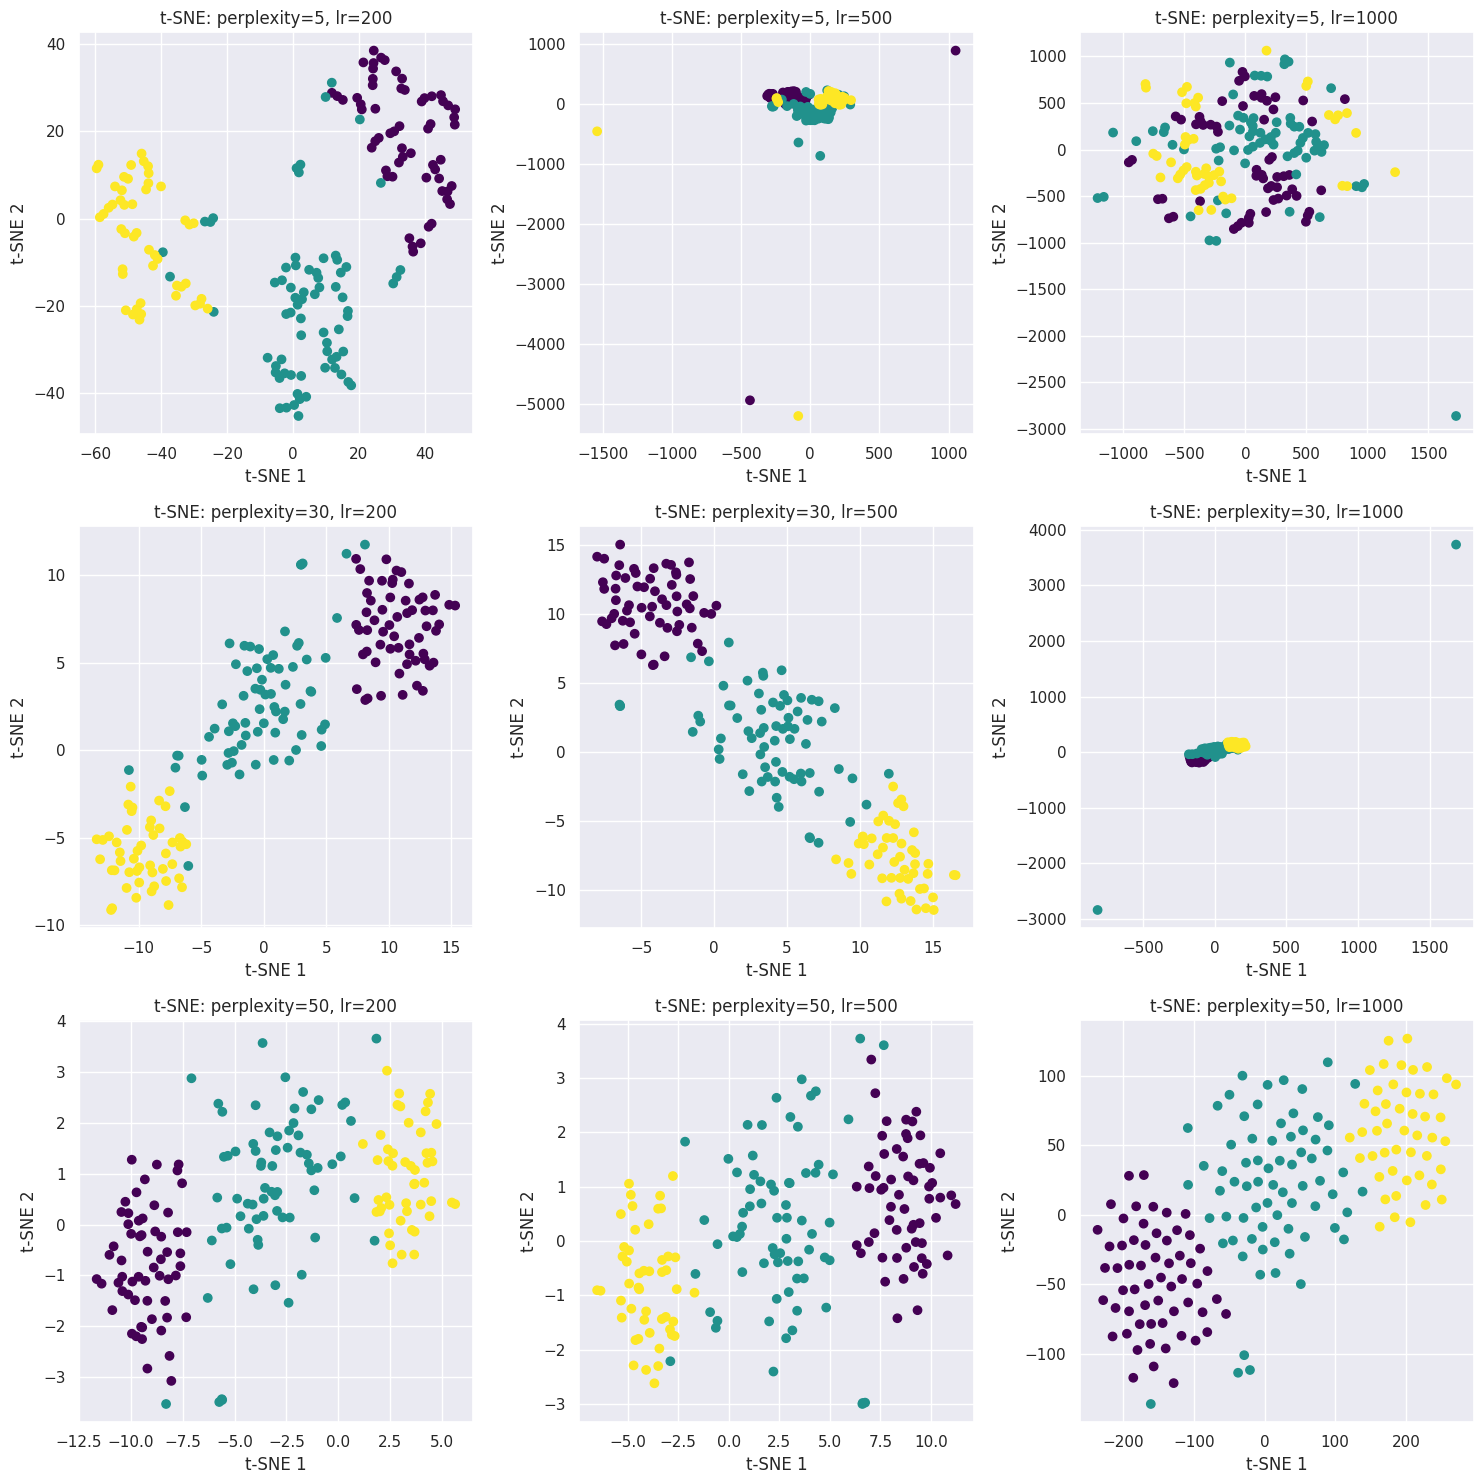

In [20]:
# Aplicar t-SNE con diferentes perplexities
perplexities = [5, 30, 50]
learning_rates = [200, 500, 1000]

fig, axes = plt.subplots(3, 3, figsize=(15, 15))

for i, perplexity in enumerate(perplexities):
    for j, lr in enumerate(learning_rates):
        tsne = TSNE(n_components=2, perplexity=perplexity, learning_rate=lr, random_state=42)
        X_tsne = tsne.fit_transform(X_scaled)

        ax = axes[i, j]
        scatter = ax.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y, cmap='viridis')
        ax.set_title(f't-SNE: perplexity={perplexity}, lr={lr}')
        ax.set_xlabel('t-SNE 1')
        ax.set_ylabel('t-SNE 2')

plt.tight_layout()
plt.show()


Efecto del Parámetro perplexity:
* Perplexity Baja (5):
Resultado: Presenta varias superposiciones

* Perplexity Media (30):
Resultado: Presenta superposiciones pero menos que perplexity 5

* Perplexity Alta (50):
Resultado: Es la que separa mejor los 3 tipos de vinos

Efecto del Parámetro learning_rate:

Solo viendo este, me costo más notar lo que estaba sucediendo. Definitavamente va cambiando pero no veo ningún patron para explicar como afecta la estructura.


 Respecto a la seperació de las tres clases
* Separación: Las tres variedades de vino forman grupos claramente distinguibles

* Mejor que PCA: La separación es más nítida que en el análisis PCA




### 3. **Comparación entre PCA y t-SNE**

* Contrastar las visualizaciones y discutir las **ventajas y limitaciones** de cada técnica:

  * PCA como método **lineal** para interpretar varianza y relaciones globales.
  * t-SNE como método **no lineal** que preserva relaciones locales y vecindades.
* Evaluar en qué escenarios prácticos sería más recomendable usar PCA (interpretabilidad, reducción previa para modelos) o t-SNE (exploración y visualización de clústeres).
* Reflexionar sobre la **importancia de la reducción de dimensionalidad** en datasets de alta dimensión como Wine, destacando su utilidad para:

  * Visualizar patrones ocultos en los datos.
  * Reducir complejidad y ruido antes de aplicar algoritmos de aprendizaje automático.
  * Facilitar la interpretación y comunicación de resultados.



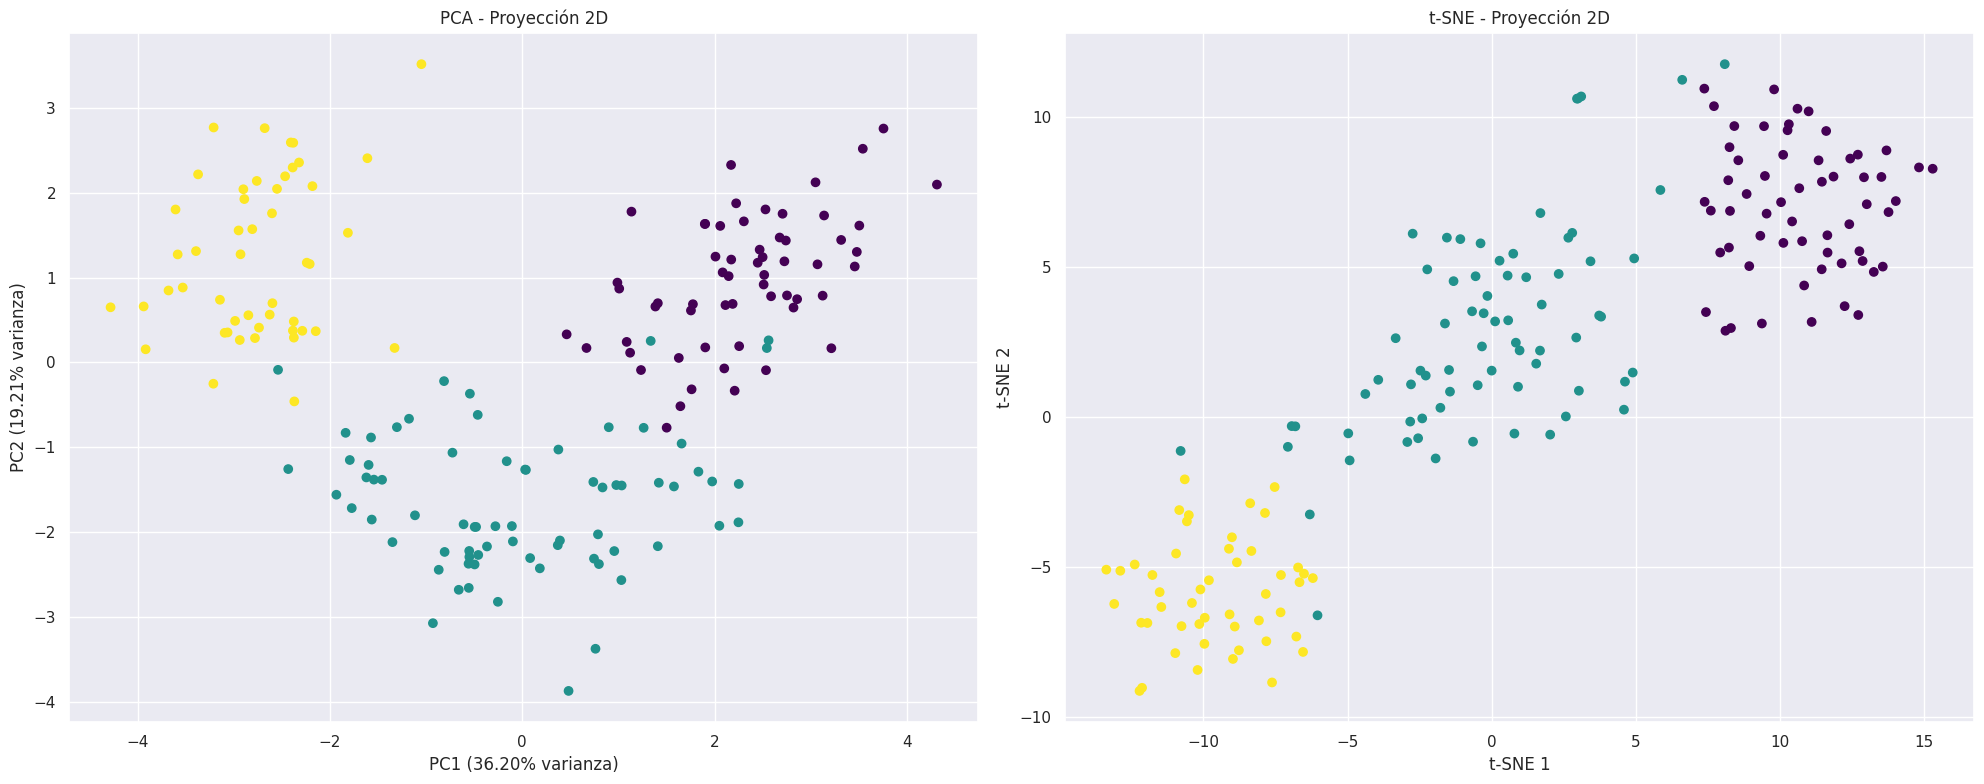

In [22]:
# Visualización comparativa
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# PCA
scatter1 = ax1.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='viridis')
ax1.set_title('PCA - Proyección 2D')
ax1.set_xlabel('PC1 ({:.2f}% varianza)'.format(varianza_explicada[0]*100))
ax1.set_ylabel('PC2 ({:.2f}% varianza)'.format(varianza_explicada[1]*100))

tsne_optimo = TSNE(n_components=2, perplexity=30, learning_rate=200, random_state=42)
X_tsne_optimo = tsne_optimo.fit_transform(X_scaled)

# t-SNE
scatter2 = ax2.scatter(X_tsne_optimo[:, 0], X_tsne_optimo[:, 1], c=y, cmap='viridis')
ax2.set_title('t-SNE - Proyección 2D')
ax2.set_xlabel('t-SNE 1')
ax2.set_ylabel('t-SNE 2')

plt.tight_layout()
plt.show()



**Comparación entre PCA y t-SNE**
* PCA: En este caso, separa bien las clases con las primeras componentes
* t-SNE: En este caso, muestra una separación más clara entre clase

Así que t-SNE es superior para visualizar agrupaciones naturales en los datos. Aunque sin ser tan estrictos para este dataset ambas técnicas muestran buena separación entre clases de vino

